In [1]:
import sys, pdb
from importlib import reload
from astropy import units as un, constants as cons
from astropy.cosmology import Planck15 as cosmo
import numpy as np
from numpy import log10 as log
sys.path.append('../pysrc/')
import GIZMO_ICs as ics

In [2]:
import warnings
warnings.filterwarnings('ignore')

## steps
* MakeDisk
    * change parameters (e.g. resolution) in ../MakeDisk_wHalo_m11_lr/main.c
    * compile with make
    * run ./MakeHubbleType ICs/m11_no_halo_#vc#_res#2e4#_fgas#05#.ic or
    * ./MakeHubbleType ICs/m11_no_halo_#vc#_res#2e4#_fgas#05#_Rcirc#1#.ic if Rcirc!=10
* create output files using script below

# example (simulation used in inflow paper)

In [3]:
fiducial = ics.ICs(vc=200*un.km/un.s, #table 4 in Fraternali+11, at Rcirc
                   Rcirc=15*un.kpc, #R25 in Fraternali+18, max radius where HI is fit in non-tail side
                   Rsonic=0.1*un.kpc, #Mdot = 2  Msun/yr = SFR/2 where SFR=3.8 is from Popescu et al. (2004)
                   resolution = 1e3*un.Msun,
                    Z_CGM=0.3, #as Milky-Way
                   fgas=0.2)

In [4]:
fiducial.calc_CF_solution(pr=True)
ind = (fiducial.CF_solution.Rs()>20*un.kpc).nonzero()[0][0]
log_nH = log(fiducial.CF_solution.nHs()[ind].value)
print('log nH(20 kpc)=%.2f, Mdot=%.3f'%(log_nH,fiducial.CF_solution.Mdot.value))

Integrated with v_c^2/c_s^2 (R_sonic) =1.000010;  maximum r=3 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.500005;  no transsonic solutions
Integrated with v_c^2/c_s^2 (R_sonic) =1.250008;  maximum r=1 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.125009;  maximum r=22 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.187508;  maximum r=34 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.156258;  maximum r=84 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.171883;  maximum r=743 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.179696;  maximum r=156 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.175789;  maximum r=941 kpc; stop reason: sonic point
Integrated with v_c^2/c_s^2 (R_sonic) =1.173836;  maximum r=2571 kpc; stop reason: unbound
Integrated with v_c^2/c_s^2 (R_sonic) =1.174813;  maximum r=2482 kpc; stop reason: sonic point
Integrated 

In [5]:
fiducial.create_output_files()

files saved to: /Users/jonathanstern/Dropbox/jonathanmain/CGM/KY_sims/ICs/vc200_Rs0_Mdot1035_Rcirc15_fgas02_res1e3
../MakeDisk_wHalo_m11_lr/ICs/m11_no_halo_200_res1e3_fgas02_Rcirc15.ic
 2r(t_cool=10Gyr) = 126 kpc, r(t_sc=20Gyr) = 3227 kpc
Part0 num=31333162, w/o CGM=20000, |<r>|=0.0, |<v>|=0.0, <j>=0.1 -0.3 1984.6,max gas id: 31333161
Ms: 1e+03 1e+03 3e+03... 5.9e+07
Part2 num=100000, |<r>|=0.0, |<v>|=0.7, <j>=-0.2 0.2 1500.6,Ms: 1e+03
Part3 num=20000, |<r>|=0.1, |<v>|=2.1, <j>=1.2 -1.2 1.7,Ms: 1e+03
Part5 num=1, |<r>|=0.0, |<v>|=0.0, <j>=0.0 0.0 0.0,Ms: 2e+05


# verification: plot integrated 1D solution

In [5]:
import pylab as pl
import matplotlib
import my_utils as u
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', family='serif', size=10)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['ytick.right'] = True
fig_width_half = 3.4
figdir = '/Users/jonathanstern/Dropbox/github_repositories/gizmo_analysis/figures/'

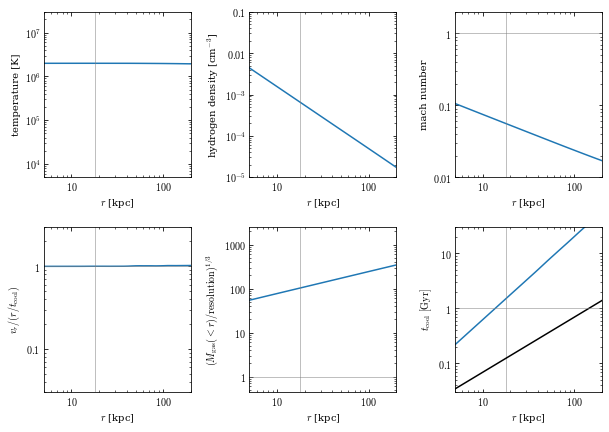

In [14]:
fig = pl.figure(figsize=(10,7))
pl.subplots_adjust(hspace=0.3,wspace=0.4)
for iPanel in range(6):
    ax = pl.subplot(2,3,iPanel+1)
    for sol in [fiducial]:
        res = sol.CF_solution
        if iPanel==0: ys = res.Ts()
        if iPanel==1: ys = res.nHs()
        if iPanel==2: ys = res.Ms()
        if iPanel==3: ys = (res.t_cools() / (res.Rs()/res.vrs())).to('')
        if iPanel==4: ys = (res.Mgas()/sol.resolution)**(1/3.)
        if iPanel==5: ys = res.t_cools() 
        pl.loglog(res.Rs(),ys)
    pl.xlim(5,200)
    pl.xlabel(r'$r$ [kpc]')
    pl.axvline(Rcirc.value,c='.5',lw=0.5)
    ax.xaxis.set_major_formatter(u.arilogformatter)
    ax.yaxis.set_major_formatter(u.arilogformatter)
    if iPanel==0:
        pl.ylabel(r'temperature [K]')
        pl.ylim(0.5e4,3e7)
    if iPanel==1: 
        pl.ylabel(r'hydrogen density [cm$^{-3}$]')
        pl.ylim(1e-5,0.1)
    if iPanel==2: 
        pl.ylabel(r'mach number')
        pl.ylim(0.01,2)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==3: 
        pl.ylabel(r'$v_r / (r/t_{\rm cool})$')
        pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==4:
        pl.ylabel(r'$(M_{\rm gas}(<r) / {\rm resolution})^{1/3}$')
#         pl.ylim(0.03,3)
        pl.axhline(1.,c='.5',lw=0.5)
    if iPanel==5: 
        pl.plot(res.Rs(),res.tff().to('Gyr'),c='k')
        pl.ylabel(r'$t_{\rm cool}\ [{\rm Gyr}]$')
        pl.ylim(0.03,30)
        pl.axhline(1.,c='.5',lw=0.5)
pl.savefig(figdir+'ICs_NGC891.pdf')

# verification: plot ICs snapshot 

In [10]:
import h5py, scipy, scipy.stats, pylab as pl
from astropy import units as un, constants as cons
%matplotlib inline
# instance = instances[0]
instance = fiducial #for Nadav's sims
init_snapshot_fn = instance.outdirname()+'/init_snapshot.hdf5'
init_snapshot = h5py.File(init_snapshot_fn,'r')

In [11]:
# disk only gas
snap = ics.gsr.Snapshot(instance.makedisk_filename())
coords = snap.SnapshotData['pos'][0]
energies = snap.SnapshotData['energies']
inds = (coords[:,1]<25) & (coords[:,1]>-25)
Xs = coords[:,0][inds]
Ys = coords[:,2][inds]
# vals = None #for counting stars
vals = energies[inds] * (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) 

In [12]:
# all gas
coords = init_snapshot['PartType0']['Coordinates']
vels = init_snapshot['PartType0']['Velocities']
inds = (coords[:,1]<5) & (coords[:,1]>-5)
Xs = coords[:,0][inds]
Zs = coords[:,2][inds]
# vals = None #for counting stars
# vals = init_snapshot['PartType0']['InternalEnergy'][inds] * (un.km**2/un.s**2 * cons.m_p / cons.k_B).to('K').value * (2./3* 0.62) 
phis = np.arctan2(vels[:,1][inds],vels[:,0][inds])

In [13]:
bins = (np.arange(-50,50,5),np.arange(-50,50,5))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Zs,
                                         vels[:,1][inds],
                                         statistic='median',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

Text(0.5, 1.0, 'all gas')

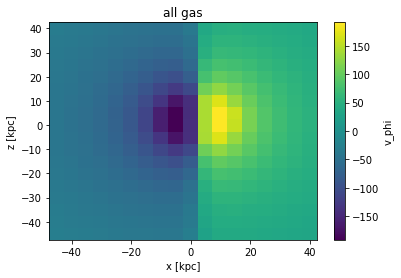

In [14]:
pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'v_phi')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('all gas')
# pl.savefig(KY_path+'../figures/ICs_allgas_vphi.pdf')

In [25]:
bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Ys,
                                         None,
                                         statistic='count',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

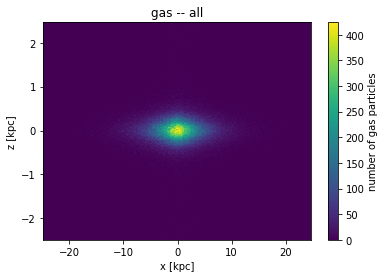

In [26]:
pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'number of gas particles')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('gas -- disk only')
pl.savefig(KY_path+'../figures/ICs_gas_temperature.pdf')

In [19]:
coords = init_snapshot['PartType2']['Coordinates']
inds = (coords[:,1]<25) & (coords[:,1]>-25)
Xs = coords[:,0][inds]
Ys = coords[:,2][inds]

In [20]:
bins = (np.arange(-25,25,0.25),np.arange(-2.5,2.5,0.025))
m,x,y,_ = scipy.stats.binned_statistic_2d(Xs,
                                         Ys,
                                         None,
                                         statistic='count',
                                         bins=bins)
x = (x[1:]+x[:-1])/2; y = (y[1:]+y[:-1])/2; 

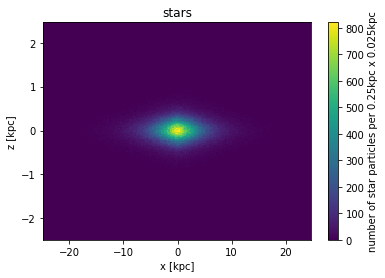

In [22]:
pl.pcolormesh(x,y,m.T)
pl.colorbar(label = 'number of star particles per 0.25kpc x 0.025kpc')
pl.xlabel('x [kpc]'); pl.ylabel('z [kpc]')
pl.title('stars')
pl.savefig(KY_path+'../figures/stellar_locations.pdf')

(1e-23, 1e-22)

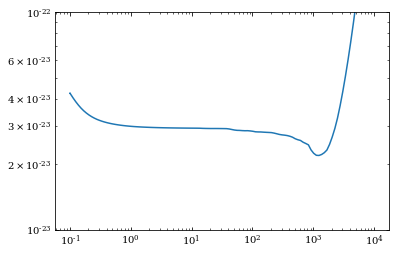

In [17]:
pl.loglog(res.Rs(), res.Lambdas())
pl.ylim(1e-23,1e-22)